In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import db_dtypes

In [9]:
client = bigquery.Client(project='first-project-321219')

query = """
WITH session_windows AS (
    -- Step 1: Define the start and end of every session
    SELECT 
        session_id,
        user_id,
        MIN(created_at) AS session_start,
        MAX(created_at) AS session_end
    FROM `bigquery-public-data.thelook_ecommerce.events`
    WHERE created_at >= '2022-01-01'
    GROUP BY 1, 2
),
order_totals AS (
    -- Step 2: Get total value for every order
    SELECT 
        user_id,
        order_id,
        created_at,
        SUM(sale_price) AS total_value
    FROM `bigquery-public-data.thelook_ecommerce.order_items`
    GROUP BY 1, 2, 3
)

SELECT 
    sw.session_id,
    sw.user_id,
    u.age,
    u.gender,
    u.country,
    u.traffic_source,
    sw.session_start,

    -- FEATURE: Total spend BEFORE this session started
    COALESCE((
        SELECT SUM(ot.total_value)
        FROM order_totals ot
        WHERE ot.user_id = sw.user_id 
          AND ot.created_at < sw.session_start
    ), 0) AS past_total_spend_before_session,

    -- FEATURE: Session count prior to this one
    COUNT(*) OVER (
        PARTITION BY sw.user_id 
        ORDER BY sw.session_start 
        ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
    ) AS number_of_prior_session_count,

    -- TARGET: Total spend WITHIN this session
    -- We look for orders by this user that happened between the session start and end
    COALESCE((
        SELECT SUM(ot.total_value)
        FROM order_totals ot
        WHERE ot.user_id = sw.user_id 
          AND ot.created_at BETWEEN sw.session_start AND sw.session_end
    ), 0) AS label_session_spend

FROM session_windows sw
JOIN `bigquery-public-data.thelook_ecommerce.users` u ON sw.user_id = u.id
ORDER BY sw.user_id, sw.session_start
"""

df = client.query(query).to_dataframe()
print(df.head())

                             session_id  user_id  age gender        country  \
0  53f4212d-da3c-413c-8009-2c362540df67        1   26      F  United States   
1  d815acfc-2672-4c85-9aad-a49a5cd1c7a8        2   17      M          Japan   
2  142f1d03-18e6-45c5-b351-b18bdd1b6c8e        3   16      M      Australia   
3  4306846f-3ded-43aa-ab67-ae1458315303        3   16      M      Australia   
4  7bfd934f-edbd-4568-981a-4af43be5bed0        4   69      F         Brasil   

  traffic_source             session_start  past_total_spend_before_session  \
0         Search 2024-09-08 16:47:28+00:00                              0.0   
1         Search 2024-12-13 22:06:40+00:00                              0.0   
2         Search 2024-11-21 13:19:14+00:00                              0.0   
3         Search 2024-11-21 14:26:51+00:00                              0.0   
4        Organic 2023-12-05 06:41:13+00:00                              0.0   

   number_of_prior_session_count  label_session_sp

In [10]:
def load_data(dataframe, datefrom = None, dateto = None):
    
    if not isinstance(dataframe, pd.DataFrame):   #isinstance(): check specified object is in specificed type.
        print('Error: Input is not a DataFrame')
        return None
  

    if 'label_session_spend' not in dataframe.columns: 
        print(f'Column Error: label_total_spend is not in DataFrame')
        return dataframe
        
    try:
        dataframe['session_start'] = pd.to_datetime(dataframe['session_start'])
    except Exception:
        print(f'Date Conversion Error: {Exception}')

    return dataframe

    

In [11]:
df_raw = load_data(X_test)
df_raw.head()
# 02/02/2026: JI: need target encoding for countries and smoothing.

,session_id,user_id,age,gender,country,traffic_source,session_start,past_total_spend_before_session,number_of_prior_session_count,label_session_spend
0,53f4212d-da3c-413c-8009-2c362540df67,1,26,F,United States,Search,2024-09-08 16:47:28+00:00,0.0,0,0.000000
1,d815acfc-2672-4c85-9aad-a49a5cd1c7a8,2,17,M,Japan,Search,2024-12-13 22:06:40+00:00,0.0,0,0.000000
2,142f1d03-18e6-45c5-b351-b18bdd1b6c8e,3,16,M,Australia,Search,2024-11-21 13:19:14+00:00,0.0,0,189.949997
3,4306846f-3ded-43aa-ab67-ae1458315303,3,16,M,Australia,Search,2024-11-21 14:26:51+00:00,0.0,1,449.939987
4,7bfd934f-edbd-4568-981a-4af43be5bed0,4,69,F,Brasil,Organic,2023-12-05 06:41:13+00:00,0.0,0,0.000000


In [5]:
# pip install category_encoders

In [12]:
from category_encoders import MEstimateEncoder

def prepare_data(df_input, target = 'label_session_spend'):
    df = df_input.copy()

    df['week_num'] = df['session_start'].dt.weekday
    df['is_weekend'] = (df['week_num'] >= 5).astype(int)
    df['session_hour'] = df['session_start'].dt.hour

    df = df.drop(['session_start', 'user_id', 'session_id'], axis = 1)

    y = df[target]
    X = df.drop(target, axis = 1)

    #one-hot encoding
    cols_obj = ['gender', 'traffic_source']

    X = pd.get_dummies(X, columns = cols_obj, drop_first = True, dtype = int)
    
    # country target encoding 
    X_encode = X.sample(frac = 0.25, random_state = 42)
    y_encode = y[X_encode.index]
    X_pretrain = X.drop(X_encode.index)
    y_train = y[X_pretrain.index]

    # choose m to control noise
    encoder = MEstimateEncoder(cols=['country'], m = 5.0)

    encoder.fit(X_encode, y_encode)

    X_train_final = encoder.transform(X_pretrain)


    # plot a chart about the convert country
    plt.figure(figsize = (8,4))
    ax = sns.histplot(y_train, kde=False,stat = 'density')
    ax = sns.kdeplot(X_train_final.country, color = 'blue', ax=ax)
    ax.set_title('Target Encoding vs Actual Distribution')
    ax.legend(labels = ['country', target])
    plt.show()

    
    return X_train_final, y_train, encoder
    

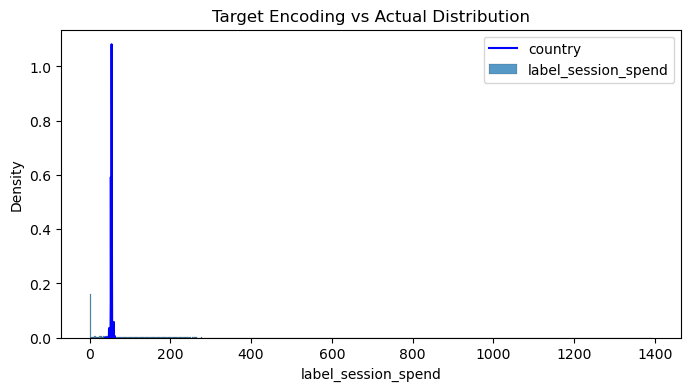

In [13]:
X_test_prepare = prepare_data(df_raw)
# y_train (the label session_spend) is close to 0. it means most customers didn't spend anything.
# X_train_final is around 50. it means there's small amount of customers spend in some countries?

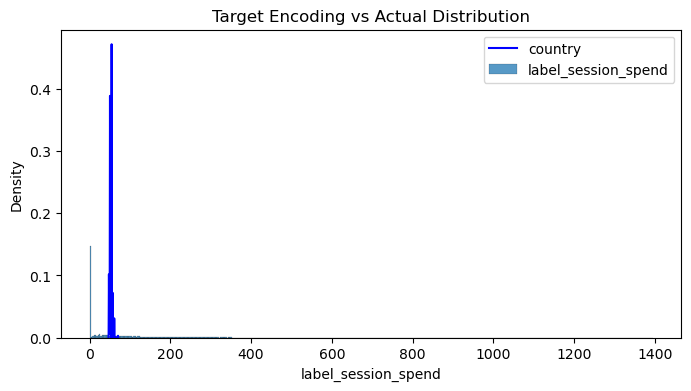

Mean Squared Error: 7182.6649
RMSE: 84.7506


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

df_train_raw, df_test_raw = train_test_split(df_raw, test_size = 0.2, random_state = 42)

X_train, y_train, country_encoder = prepare_data(df_train_raw)

X_test = df_test_raw.copy()

X_test['week_num'] = X_test['session_start'].dt.weekday
X_test['is_weekend'] = (X_test['week_num'] >= 5).astype(int)
X_test['session_hour'] = X_test['session_start'].dt.hour

y_test = X_test['label_session_spend']
X_test = X_test.drop(['session_start', 'user_id', 'session_id', 'label_session_spend'], axis = 1)


#one-hot encoding
cols_obj = ['gender', 'traffic_source']

X_test = pd.get_dummies(X_test, columns = cols_obj, drop_first = True, dtype = int)

# ensure number of X_test columns are the same as X_train
X_test = X_test.reindex(columns = X_train.columns, fill_value = 0)
    
X_test_final = country_encoder.transform(X_test)

# Decision Tree model
regressor = DecisionTreeRegressor(max_depth = 5, random_state = 42)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test_final)

# validation
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
rmse = mse ** 0.5
print(f'RMSE: {rmse:.4f}')

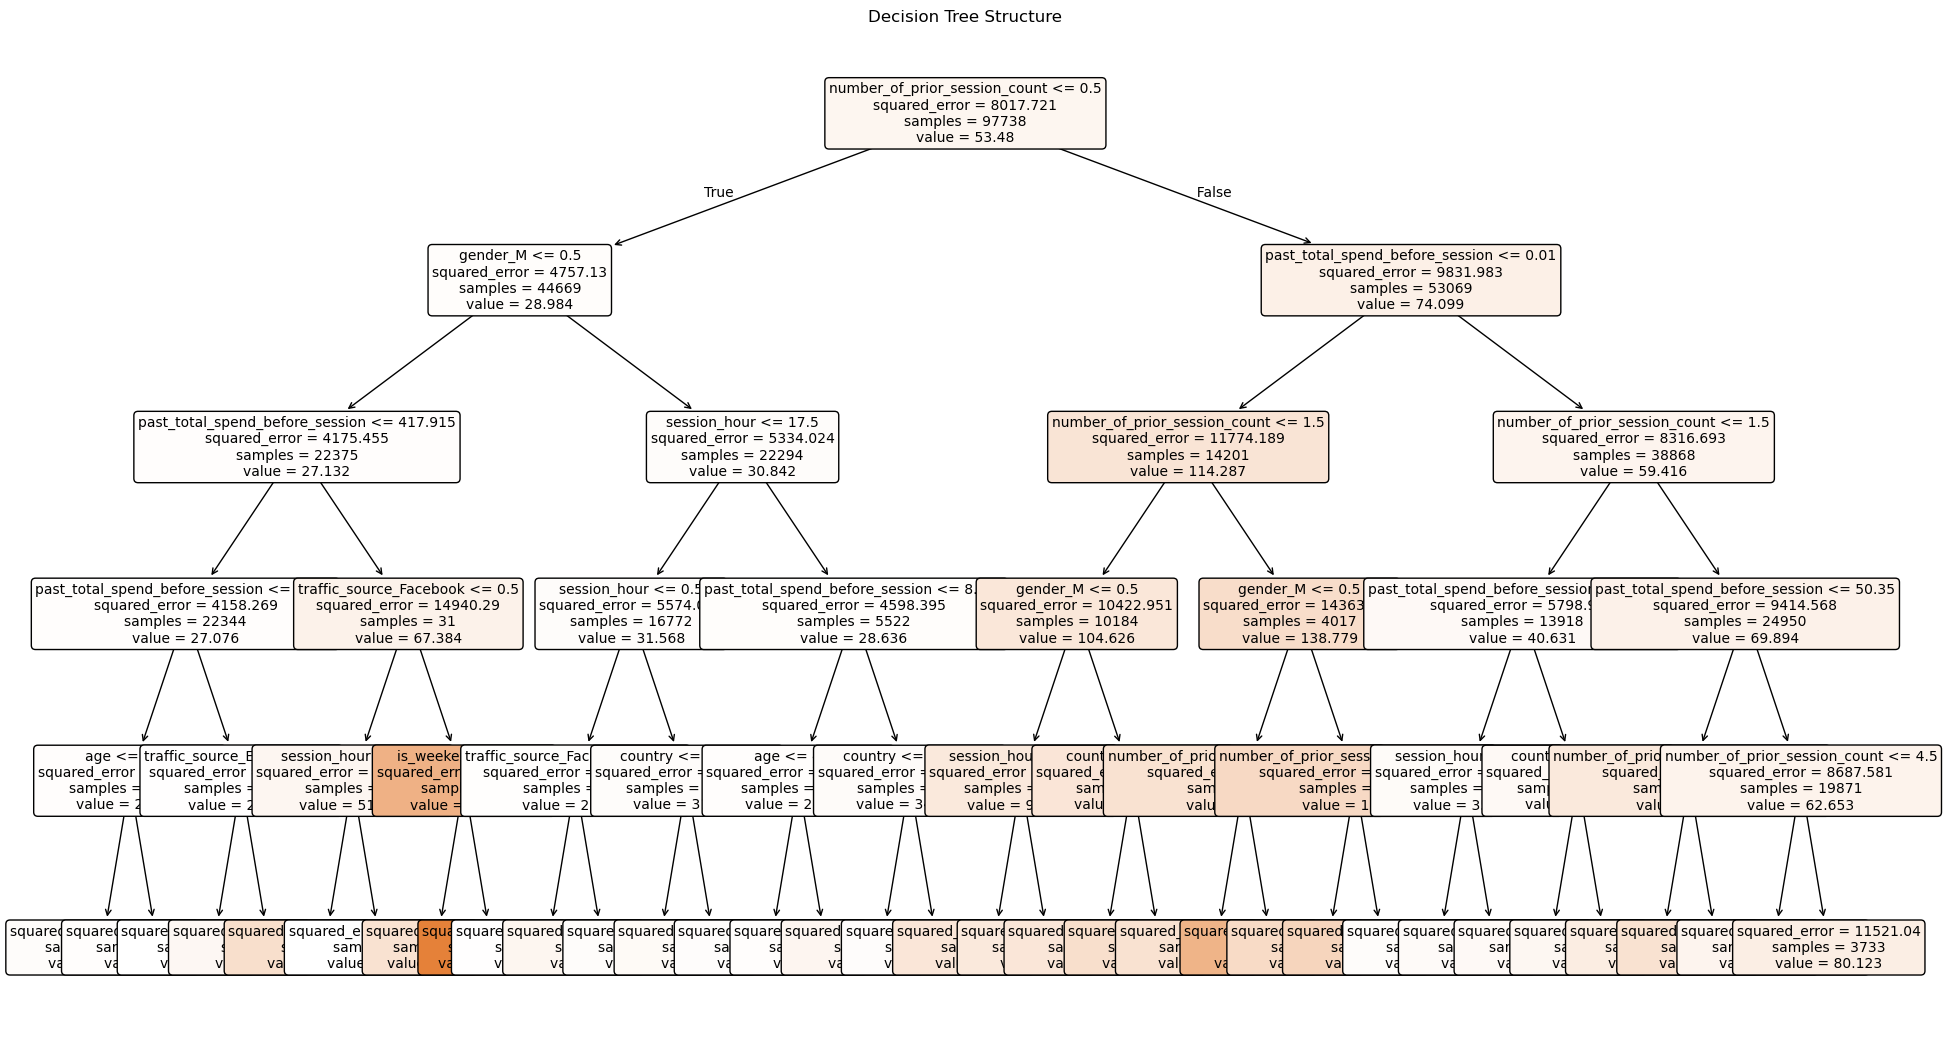

In [15]:
from sklearn.tree import plot_tree

plt.figure(figsize = [23,13])
plot_tree(
        regressor,
        feature_names = X_train.columns.tolist(),
        filled = True,
        rounded=True,
        fontsize=10
)
plt.title('Decision Tree Structure')
plt.show()